# Introduction: Telecom Churn Dataset (IBM Watson Analytics)

Customer churn, also known as customer attrition or customer turnover, is the loss of a client or customer. Customer churn is a key business metric for many different industries; in this case telecommunications technologies. Predicting customer churn has many advantages in solidfying and maximizing customer base. This is because holding onto an existing long-term client is less costly than acquring a new client. Our predictive model could then be used to better help the customer service department select which clients are at greater risk of attrition and respond accordingly to reduce the risk of losing valued clientele.

The Telecom Churn Dataset from IBM Watson Analytics is comprised of customer data and customer attrition status gained from IBM customers. Customers who have stopped doing business with IBM are listed in our target variable 'Churn' and assigned a 'Yes' value indicating customer attrition. Our goal is to create a machine learning model that will predict the target variable customer churn and test which machine learning model performs best with our data using various classification metrics.

In [ ]:
from portfolio_utils import set_seed
set_seed(42)

# Import necessary packages.
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import io
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import time
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import warnings

# Suppress warnings.
warnings.filterwarnings("ignore")

# Data loaded in next cell via portfolio_utils or Colab upload.


In [ ]:
# Load data: run setup_data.py once, or set DATA_DIR
try:
    from portfolio_utils.data_loader import load_telecom_churn
    df = load_telecom_churn()
except Exception:
    import os
    from pathlib import Path
    path = Path(os.environ.get("DATA_DIR", "data")) / "telecom_churn"
    csvs = list(path.rglob("*.csv")) if path.exists() else []
    if csvs:
        df = pd.read_csv(csvs[0])
    else:
        import io
        from google.colab import files
        uploaded = files.upload()
        key = [k for k in uploaded if k.endswith(('.xlsx','.xls','.csv'))][0]
        if key.endswith('.csv'):
            df = pd.read_csv(io.BytesIO(uploaded[key]))
        else:
            df = pd.read_excel(io.BytesIO(uploaded[key]))
print(f"Loaded shape: {df.shape}")


We have now stored our data in a Pandas DataFrame for further analysis. We can get a feel for the dataset before processing by taking a look at the features above. Some features will need to be cleaned as they do not contribute to our data like individual customer ID contained in the customerID feature. Other features will need to be converted from categorical inputs to numerical inputs for machine learning.

# Exploratory Data Analysis and Visualization

In [3]:
# Looking at our DataFrames info we see a majority of our data type is categorical, with a few integer and float columns.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# We have no missing values which makes our data a little easier to work with.
df.isnull().mean() * 100

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [5]:
# We can drop our customer ID column as it is not relevant to our target variable. TotalCharges will also be dropped as it only consists of a few values.
df = df.drop(columns = ['customerID', 'TotalCharges'])

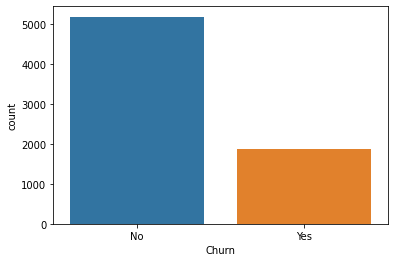

In [6]:
# Plotting a countplot of our target variable, customer churn using Seaborn.
# We can see some class imbalance occuring with our non-attrited customer base outnumbering our attrited customer base.
sns.countplot(x ='Churn', data = df)

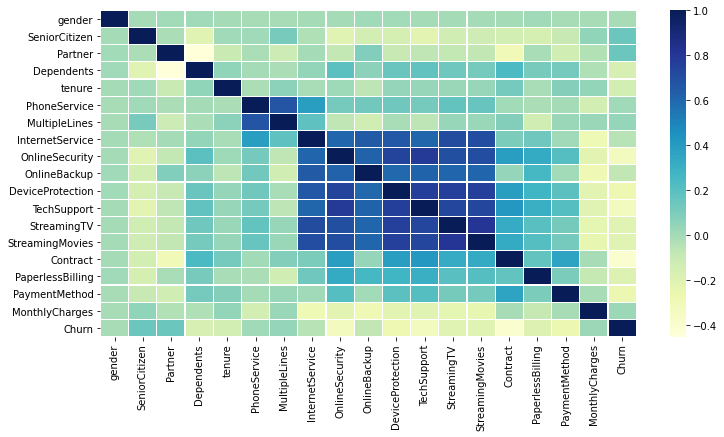

In [7]:
# Plotting a correlation heatmap to give us a visual representation of our correlation matrix. 
plt.figure(figsize=(12, 6))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

We can see some features of interest showing a higher correlation value like 'SeniorCitizen' and 'MultipleLines' in regards to our target variable 'Churn' on the far-right column and bottom row. 

### Outlier Detection

Visually analyzing continuous variables for any outliers that may affect our prediction with a boxplot.


{'boxes': [<matplotlib.lines.Line2D at 0x7fc4de017048>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc4de017a58>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc4ddfed518>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fc4ddfed198>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc4de017358>,
  <matplotlib.lines.Line2D at 0x7fc4de0176d8>]}

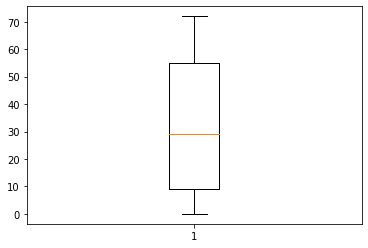

In [8]:
# Using pyplot to generate a simple boxplot of our continuous variable 'tenure'.
plt.boxplot(df["tenure"])

Tenure has no visible outliers as seen on the boxplot. These would have been visible as dots along the outer whiskers of the boxplot if there were outliers detected outside of the interquartile range.

{'boxes': [<matplotlib.lines.Line2D at 0x7fc4dcd73a20>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc4dcd80470>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc4dcd80ef0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fc4dcd80b70>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc4dcd73d30>,
  <matplotlib.lines.Line2D at 0x7fc4dcd800f0>]}

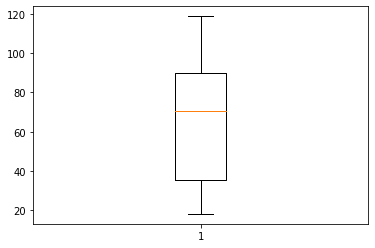

In [9]:
# Using pyplot to generate a simple boxplot of our continuous variable 'MonthlyCharges'.
plt.boxplot(df["MonthlyCharges"])

The MonthlyCharges feature is also not showing any signs of outliers visually as there are no data points being generated outside of our boxplot's whiskers. We will next confirm this statistically with NumPy's percentile function to generate an interquartile range and test accordingly for any values that are outside of our IQR. It is best practice to confirm any visual clues with a statistical test instead of making assumptions based on visuals.

In [10]:
# Calculating the IQR using NumPy's percentile function, which returns the q-th percentile(s) of the array elements.
q75, q25 = np.percentile(df["MonthlyCharges"], [75 ,25])
iqr = q75 - q25

# Creating a range of threshold values to test using NumPy in intervals of 0.5.
for threshold in np.arange(1,5,0.5):
# Creating minimum outlier threshold value.
    min_val = q25 - (iqr*threshold)
# Creating maximum outlier threshold value.
    max_val = q75 + (iqr*threshold)
# Printing score threshold and resulting number of outliers detected.
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df["MonthlyCharges"] > max_val) 
                      | (df["MonthlyCharges"] < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 0
The score threshold is: 1.5
Number of outliers is: 0
The score threshold is: 2.0
Number of outliers is: 0
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


We found no outliers using various outlier thresholds and IQR to establish  thresholds statistically. The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

# Class Balancing

The target variable Churn consists of more data for non-churned employees and is therefore class imbalanced. While this may be good for our organizations performance, it is not going to help our machine learning models perform any better. This will effect our model outcome and create bias towards the highest numbered class, which in this case is our non-attrited customer base. We will apply SMOTE (Synthetic Minority Over-sampling Technique) to increase our minority class synthetically before splitting our data since we do not have enough data to perform undersampling techniques in this situation.

# Split our DataSet.

In [11]:
# y is our target variable employee churn. We drop our target from X.
y = df['Churn']
X = df.drop(columns=['Churn'])

# Use pandas get_dummies function to create dummy variables necessary for statistical interpretation during machine learning.
X = pd.get_dummies(X)

# Class balancing the target using SMOTE, we will use the minority sampling class strategy since we want to oversample our smaller target variable class.
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Fit SMOTE to our X and y variables.
X, y = sm.fit_resample(X, y)

# Splitting dataset into a training set and test set using a test size of 20%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

Now that we have cleaned our data, and created our target variable while fixing class imbalance, our data is now ready for machine learning.

# Logistic Regression Classifier

In [ ]:
# Timing our model.
start_time = time.time()

# Adjust our max iteration value, 100 is too low and gives errors.
clf = LogisticRegression(max_iter=400).fit(X_train, y_train)

print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.865 seconds ---


Our logistic regression classifier model ran rather fast without any feature selection or decompostion in about only 0.8 seconds. Logistic regression classification is well-suited for this task as our target variable has a binary output.

In [ ]:
# Cross validation score for Logistic Regression Classifier.
cross_val_score(clf, X_train, y_train, cv=10)

array([0.77294686, 0.77777778, 0.74637681, 0.75362319, 0.75483092,
       0.78623188, 0.78019324, 0.77415459, 0.75453446, 0.79443773])

We are only seeing some minor variance in cross-validation scores which is a good sign. This means our model is expected to generalize new data. We are also not seeing any signs of over-fitting in our cross-validation scoring which would appear as sporadic over-fitting.

In [ ]:
# Building classification report for our logistic regression classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7840579710144927
Classification report:
              precision    recall  f1-score   support

          No       0.80      0.75      0.77      1021
         Yes       0.77      0.82      0.79      1049

    accuracy                           0.78      2070
   macro avg       0.79      0.78      0.78      2070
weighted avg       0.79      0.78      0.78      2070

Confusion matrix:
[[765 256]
 [191 858]]


Our model is working moderately well in our classification report above. Our classification report metrics do leave room for improvement however with only somewhat above average scoring in precision, accuracy, recall, and f1-score metrics. We are seeing a slight tradeoff in precision and recall values for the two classes. Our confusion matrix also shows a more than desirable number of false positives and false negatives. 

# Gradient Boosting Classifier

In [ ]:
# Timing our model.
start_time = time.time()

# Creating gradient boost classifier.
clf = GradientBoostingClassifier()

# Fitting model to our data.
clf.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 2.205 seconds ---


We have a slightly longer runtime than our logistic regression classifier above with over 2 seconds runtime for gradient boosting classification. Although this could be interpreted as only 1 second longer runtime, it could also be interpreted as double the runtime. This means that we may see double runtimes with larger datasets. This is something to keep in mind when evaluating model performance and adapting it to larger datasets.

In [ ]:
# Cross validation score for Gradient Boosting Classifier.
cross_val_score(clf, X_train, y_train, cv=10)

array([0.86231884, 0.85024155, 0.85024155, 0.83091787, 0.88405797,
       0.87198068, 0.85024155, 0.87077295, 0.83192261, 0.87061669])

Our gradient boosting model is giving us minimal cross-validation variance of about 5%. Cross-validation scoring is also about 9-10% higher than the logistic regression classifier. Cross-validation scoring for gradient boosting classification is not indicative of any overfitting or underfitting with consistent scoring across the ten cross-validations.

In [ ]:
# Classification report for our Gradient Boosting classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.8628019323671497
Classification report:
              precision    recall  f1-score   support

          No       0.86      0.86      0.86      1021
         Yes       0.86      0.87      0.86      1049

    accuracy                           0.86      2070
   macro avg       0.86      0.86      0.86      2070
weighted avg       0.86      0.86      0.86      2070

Confusion matrix:
[[878 143]
 [141 908]]


Precision, recall, accuracy, and f1-score metrics are all showing better model performance for the gradient boosting classification report compared to logistic regression classification. Precision and recall tradeoff is minor. Our confusion matrix is also showing less false positive and less false negative values.

Accuracy is surpassing that of logistic regression by around 8%. However, this model took some additional time to run with over double the runtime so we have a tradeoff in scoring and runtime compared to the logistic regression classification model. 

# KNN Classifier

In [ ]:
# Timing our model.
start_time = time.time()

#Create the KNN Classifier.
knn = KNeighborsClassifier(n_neighbors=7)

#Train our model.
knn.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.052 seconds ---


Very fast run time with KNN classifier clocking in at 0.052 seconds using no feature selection or feature decomposition. 

In [ ]:
# Cross validation score for KNN.
cross_val_score(knn, X_train, y_train, cv=10)

array([0.79227053, 0.77898551, 0.76690821, 0.78140097, 0.77415459,
       0.80193237, 0.76086957, 0.78381643, 0.77025393, 0.81620314])

There is some cross variance of about 5% as seen in the previous classification models. We are also seeing similar but slightly higher cross-validation scoring in comparison to our logistic regression classifier however at a fraction of the runtime. 



In [ ]:
# Classification report for our KNN classifier.
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7913043478260869
Classification report:
              precision    recall  f1-score   support

          No       0.89      0.66      0.76      1021
         Yes       0.73      0.92      0.82      1049

    accuracy                           0.79      2070
   macro avg       0.81      0.79      0.79      2070
weighted avg       0.81      0.79      0.79      2070

Confusion matrix:
[[673 348]
 [ 84 965]]


We are seeing a major tradeoff between precision and recall metrics in both classes of our target variable. This is also shown in the imbalanced confusion matrix, although accuracy scoring is remaining consistent. So although we have reduced our runtime we are also seeing reduced performance in key performance metrics.

# SVM Classifier

In [ ]:
# Timing our model.
start_time = time.time()

#Create svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train our model
clf.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 68.297 seconds ---


Our SVM model has significantly longer run time than that of our previous models. This is because SVM is a very memory intensive model, and runtime can grow exponentially with increased data size. SVM must make many exhaustive calculations to create the parameters needed for machine learning.

In [ ]:
# Cross validation score for SVM.
cross_val_score(clf, X_train, y_train, cv=10)

array([0.75845411, 0.75603865, 0.71014493, 0.71014493, 0.72705314,
       0.76328502, 0.76328502, 0.73550725, 0.74607013, 0.78839178])

We are seeing some cross-validation score variance of about 7%. This is somewhat higher than previous models. The cross-validation scoring does not show any fitment issues and should be expected to generalize new data however.

In [ ]:
# Classification report for our SVM classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
svm_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(svm_report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7541062801932367
Classification report:
              precision    recall  f1-score   support

          No       0.81      0.65      0.72      1021
         Yes       0.72      0.85      0.78      1049

    accuracy                           0.75      2070
   macro avg       0.76      0.75      0.75      2070
weighted avg       0.76      0.75      0.75      2070

Confusion matrix:
[[668 353]
 [156 893]]


This does not seem like a good model to use for this dataset with such a long run time and no advantages in cross-validation scoring, variance or classification report metrics.

# Decision Tree Classifier

In [19]:
# Creating initial tree for GridSearchCV to run.
decision_tree = tree.DecisionTreeClassifier()

# We are looking at a few parameters to see what works best with our model.
tree_para = {'criterion':['gini','entropy'],
             'max_depth':[5,10,20,50,100,150],
             'max_features':[10,20,30,44]}
clf = GridSearchCV(decision_tree, tree_para, cv=5)
clf.fit(X_train, y_train)

# Putting our results into a Pandas DataFrame for easier interpretation.
gscv_df = pd.DataFrame(clf.cv_results_)
gscv_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.019310,0.002065,0.003709,0.000378,gini,10,10,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.818841,0.798913,0.832729,0.819335,0.822961,0.818556,0.011017,1
29,0.034552,0.001213,0.003404,0.000051,entropy,10,20,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.834541,0.795290,0.831522,0.805438,0.825378,0.818434,0.015385,2
6,0.034809,0.000669,0.003401,0.000066,gini,10,30,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.828502,0.797705,0.833937,0.801813,0.825378,0.817467,0.014773,3
30,0.045750,0.002278,0.003374,0.000082,entropy,10,30,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.816425,0.798913,0.832126,0.821148,0.817523,0.817227,0.010710,4
31,0.061669,0.000852,0.003378,0.000045,entropy,10,44,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.820652,0.804952,0.821860,0.810876,0.827190,0.817106,0.008042,5
5,0.026212,0.001154,0.003349,0.000028,gini,10,20,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.821860,0.791667,0.824879,0.816314,0.824773,0.815899,0.012508,6
7,0.047074,0.000561,0.003379,0.000036,gini,10,44,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.819444,0.798309,0.826691,0.813897,0.812085,0.814085,0.009387,7
28,0.021932,0.001544,0.003849,0.000562,entropy,10,10,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.817633,0.775966,0.823068,0.810876,0.809668,0.807442,0.016465,8
46,0.058782,0.001765,0.003480,0.000064,entropy,150,30,"{'criterion': 'entropy', 'max_depth': 150, 'ma...",0.814010,0.786232,0.810990,0.790937,0.829003,0.806234,0.015720,9
3,0.032609,0.001549,0.003471,0.000376,gini,5,44,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.817029,0.772947,0.814614,0.809668,0.813293,0.805510,0.016455,10


In [20]:
# Timing our model.
start_time = time.time()

# Initialize and train our tree using best parameters from GridSearchCV.
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    max_features=10,
)
decision_tree.fit(X_train, y_train)

# Print model runtime. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.028 seconds ---


Decision tree classification is displaying a faster runtime than our KNN classifier, almost half the runtime.

In [21]:
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.82125604, 0.82608696, 0.79347826, 0.78140097, 0.83695652,
       0.83695652, 0.8236715 , 0.8321256 , 0.80411125, 0.83675937])

Examining cross validation score for our decision tree we are seeing some variance of about 5%, our model is showing no signs of overfitting or underfitting to new data at different cross-validation points.

In [22]:
# Print accuracy score, confusion matrix, and classification report metrics for our Decision Tree.
y_pred = decision_tree.predict(X_test)
dt_accuracy = accuracy_score(y_test,y_pred)
decision_tree_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", dt_accuracy)
print("Classification report:")
print(decision_tree_report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.8227053140096618
Classification report:
              precision    recall  f1-score   support

          No       0.82      0.83      0.82      1021
         Yes       0.83      0.82      0.82      1049

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070

Confusion matrix:
[[846 175]
 [192 857]]


Weighted average metrics are displaying a similar level of performance as previous models. Accuracy score is desirable considering the runtime reduction. Decision tree classifier is showing the fastest performance so far without features selection or decomposition.

# Random Forest Classifier

In [13]:
# Creating a Random Forest Classifier to use with GridSearchCV.
rfc = ensemble.RandomForestClassifier()

# Creating a parameter grid to find best combination of hyperparameters. 
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [10,20,30,44],
    'criterion' :['gini', 'entropy']
}

# Using GridSearchCV to find best hyperparamater combination.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

# Fitting GridSearchCV to our newly decomposed data.
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [14]:
# Calling best_params_ to find best parameters from GridSearchCV.
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 200}

In [15]:
# Timing our model.
start_time = time.time()

# Creating our model using optimized hyperparameters from GridSearchCV.
rfc = ensemble.RandomForestClassifier(criterion='entropy', 
                                      max_depth=20,
                                      max_features='auto',
                                      n_estimators=200, random_state=42)

# Fit our newly decomposed data to our model.
rfc.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 2.713 seconds ---


Random forest classification is running very fast at a time of 2.7 seconds. This indicates that random forest classification is performing moderately well with a manageable runtime in comparison to our faster models. 

In [16]:
# Cross-valdiation score for our Random Forest Classifier.
cross_val_score(rfc, X_train, y_train, cv=10)

array([0.85990338, 0.85386473, 0.84299517, 0.82608696, 0.87318841,
       0.87077295, 0.83333333, 0.85628019, 0.85126965, 0.87424426])

We are seeing cross-validation variance of around 4% meaning our model is performing consistently and can be expected to handle new data without huge differences in cross-variance scores. We see no signs of overfit or underfit.

In [17]:
# Print classification report for Random Forest Classifier.
y_pred = rfc.predict(X_test) 
rfc_accuracy = accuracy_score(y_test,y_pred)
rfc_report = classification_report(y_test, y_pred)
rfc_cm = confusion_matrix(y_test, y_pred)

print("Classification report:")
print("Accuracy: ", rfc_accuracy)
print(rfc_report)
print("Confusion matrix:")
print(rfc_cm)

Classification report:
Accuracy:  0.8685990338164251
              precision    recall  f1-score   support

          No       0.85      0.89      0.87      1021
         Yes       0.89      0.85      0.87      1049

    accuracy                           0.87      2070
   macro avg       0.87      0.87      0.87      2070
weighted avg       0.87      0.87      0.87      2070

Confusion matrix:
[[905 116]
 [156 893]]


We see some minor tradeoff in our crossvalidation report between precision and recall but to a much smaller degree than the previous machine learning models. Our ensemble model is performing much better than our decision tree model and all other models above. We will research further by looking at feature selection and decomposition methods combined with hyperparameter optimization to fine tune our model performance and get the best results.

# Select K Best Feature Selection

We can reduce our feature dimensions and choose the most relevant features based on K value with sklearn's SelectKBest function. Let's see if feature selection can improve our runtime or classification report metrics where we had problems with tradeoff between recall and precision earlier.

In [15]:
# Creating target variable.
y = df['Churn']

# Creating X values by dropping our target.
X = df.drop(columns=['Churn'])

# Use pandas get_dummies function to create dummy variables necessary for statistical interpretation (One Hot Encoding).
X = pd.get_dummies(X)

# Run our selector using f_classif for our classification task.
selector = SelectKBest(f_classif).fit(X, y)

# Create boolean values to select features from original feature set using get_support.
boolean = selector.get_support()

# Our new X variable now consists of our selected best features based on K value.
X_new = X[X.columns[boolean]]

# Class balancing using SMOTE.
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Fitting SMOTE to resample our target class.
X_new, y = sm.fit_resample(X_new, y)

In [16]:
# Let's split our data, this time using our newly selected features.
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.20, stratify=y, random_state=42)

In [17]:
# Shape of X before selectkbest is applied.
X.shape

(7043, 44)

In [18]:
# Select K best has successfully reduced our number of features from 44 to 10.
# We've also synthetically increased our minority class as seen here in the final shape.
X_new.shape

(10348, 10)

# Logistic Regression Classifier with SelectKBest Feature Selection



In [ ]:
# Timing our model.
start_time = time.time()

#Adjust our max iteration value, 100 is too low and gives errors.
clf = LogisticRegression(max_iter=400).fit(X_train, y_train)

# Print model runtime. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.202 seconds ---


Our run time is much better than before we performed feature selection. We have successfully reduced our run time by about 75% using SelectKBest. This is due to the decreased dimensionality of our new feature set. 

In [ ]:
# Print cross validation score.
cross_val_score(clf, X_train, y_train, cv=10)

array([0.76811594, 0.76086957, 0.73429952, 0.72101449, 0.72705314,
       0.77173913, 0.73913043, 0.74516908, 0.74727932, 0.7859734 ])

Logistic regression classification cross-validation scoring is displaying the same attributes before feature selection with no signs of overfitting or underfitting and variance in scoring of about 5%.

In [ ]:
# Classification report for our Logistic Regression Classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7608695652173914
Classification report:
              precision    recall  f1-score   support

          No       0.79      0.71      0.74      1021
         Yes       0.74      0.81      0.78      1049

    accuracy                           0.76      2070
   macro avg       0.76      0.76      0.76      2070
weighted avg       0.76      0.76      0.76      2070

Confusion matrix:
[[722 299]
 [196 853]]


Our models accuracy was reduced by about 2% but this is not a bad trade-off considering the reduction in run-time. This is due to losing some information during feature selection with selectkbest. Precision and recall tradeoff seen here is slightly increased in comparison to our logistic regression classifier before feature selection.

# Gradient Boosting Classifier with SelectKbest Feature Selection

In [ ]:
# Timing our model.
start_time = time.time()

# Creating gradient boosting classifier.
clf = GradientBoostingClassifier()

# Fit classifier to training data.
clf.fit(X_train, y_train)

# Print model runtime. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.536 seconds ---


SelectKBest feature selection greatly reduced our run time again by about 75%.

In [ ]:
cross_val_score(clf, X_train, y_train, cv=10)

array([0.79468599, 0.76690821, 0.73913043, 0.73792271, 0.75603865,
       0.77898551, 0.75603865, 0.75724638, 0.75211608, 0.80169287])

We are seeing more cross-validation score variance here than our initial gradient boosting classifier without feature selection. 

In [ ]:
# Classification report for our Gradient Boosting classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7729468599033816
Classification report:
              precision    recall  f1-score   support

          No       0.80      0.72      0.76      1021
         Yes       0.75      0.83      0.79      1049

    accuracy                           0.77      2070
   macro avg       0.78      0.77      0.77      2070
weighted avg       0.78      0.77      0.77      2070

Confusion matrix:
[[731 290]
 [180 869]]


Reduction in accuracy and other classification report metrics shows our model performance is lowered due to loss of information during feature selection.

# KNN Classifier with SelectKBest Feature Selection

In [ ]:
# Timing our model.
start_time = time.time()

#Create the KNN Classifier.
knn = KNeighborsClassifier(n_neighbors=7)

#Train our model.
knn.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.021 seconds ---


We further reduced our run time by more than half using selectkbest feature selection. This is due to decreased dimensionality therefore decreased computation time. 

In [ ]:
cross_val_score(knn, X_train, y_train, cv=10)

array([0.79951691, 0.76207729, 0.76690821, 0.73188406, 0.75241546,
       0.77777778, 0.76932367, 0.77173913, 0.75211608, 0.7980653 ])

Our KNN classifer model with feature selection is displaying similar variance before selection of 6% in our cross-validation score. Cross-validation score is not showing any signs of overfitting or underfitting.

In [ ]:
# Classification report for our KNN classifier.
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7830917874396135
Classification report:
              precision    recall  f1-score   support

          No       0.85      0.68      0.75      1021
         Yes       0.74      0.89      0.81      1049

    accuracy                           0.78      2070
   macro avg       0.80      0.78      0.78      2070
weighted avg       0.79      0.78      0.78      2070

Confusion matrix:
[[691 330]
 [119 930]]


We are seeing very similar performance with this model to the KNN classification model before feature selection. Weighted average scoring for precision, recall, and f1-score are reduced by a couple of points. This seems to be worth the tradeoff of redcing model runtime by half.

# SVM Classifier with SelectKBest Feature Selection

In [ ]:
# Timing our model.
start_time = time.time()

#Create SVM Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train our model
clf.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 3.097 seconds ---


We have a much better run time than that of our initial model of around 60 seconds, reducing runtime by a minute woth selectkbest feature selection.

In [ ]:
cross_val_score(clf, X_train, y_train, cv=10)

array([0.75966184, 0.75362319, 0.7089372 , 0.70289855, 0.71980676,
       0.75603865, 0.75      , 0.72705314, 0.73518742, 0.77750907])

Cross-validation score variance is about the same around 7%. Cross-validation scoring shows no signs of overfitting or underfitting.

In [ ]:
# Classification report for our SVM classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
svm_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(svm_report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7463768115942029
Classification report:
              precision    recall  f1-score   support

          No       0.80      0.65      0.72      1021
         Yes       0.71      0.84      0.77      1049

    accuracy                           0.75      2070
   macro avg       0.75      0.75      0.74      2070
weighted avg       0.75      0.75      0.74      2070

Confusion matrix:
[[668 353]
 [172 877]]


We have a minor loss in accuracy of about 1% compared to before feature selection with selectkbest. This is a great tradeoff for such a dramatic reduction in runtime and shows how effective feature selection is in some use cases.

# Decision Tree Classifier with SelectKBest Selected Features and Optimized Hyperparameters

In [85]:
# We are looking at a few parameters to see what works best with our model.
tree_para = {'criterion':['gini','entropy'],
             'max_depth':[5,10,20,50,100,150],
             'max_features':[3,4,5,10]}
clf = GridSearchCV(decision_tree, tree_para, cv=5)
clf.fit(X_train, y_train)

# Putting our results into a Pandas DataFrame for easier interpretation.
gscv_df = pd.DataFrame(clf.cv_results_)
gscv_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
31,0.020605,0.000654,0.003343,0.000060,entropy,10,10,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.834541,0.787440,0.833333,0.813293,0.825378,0.818797,0.017413,1
7,0.019417,0.002210,0.003316,0.000033,gini,10,10,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.814010,0.791667,0.816425,0.823565,0.815710,0.812275,0.010809,2
6,0.013329,0.000474,0.003262,0.000051,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.815217,0.783816,0.826691,0.801813,0.822961,0.810100,0.015661,3
10,0.015925,0.000396,0.003470,0.000088,gini,20,5,"{'criterion': 'gini', 'max_depth': 20, 'max_fe...",0.816425,0.777778,0.808575,0.810272,0.804834,0.803577,0.013432,4
32,0.016222,0.000835,0.003416,0.000020,entropy,20,3,"{'criterion': 'entropy', 'max_depth': 20, 'max...",0.801932,0.783213,0.823068,0.795770,0.810272,0.802851,0.013420,5
29,0.014075,0.000556,0.003298,0.000038,entropy,10,4,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.810386,0.781401,0.824879,0.788520,0.809063,0.802850,0.015787,6
30,0.016497,0.001058,0.003357,0.000049,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.807367,0.771135,0.814010,0.804834,0.815710,0.802611,0.016247,7
39,0.026972,0.000811,0.003483,0.000058,entropy,50,10,"{'criterion': 'entropy', 'max_depth': 50, 'max...",0.798309,0.783213,0.806763,0.804834,0.819335,0.802491,0.011804,8
4,0.011328,0.000208,0.003281,0.000111,gini,10,3,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.820048,0.777174,0.794082,0.811480,0.809668,0.802490,0.015180,9
23,0.022232,0.000967,0.003469,0.000034,gini,150,10,"{'criterion': 'gini', 'max_depth': 150, 'max_f...",0.793478,0.792874,0.815821,0.785498,0.821148,0.801764,0.014040,10


We've ordered the DataFrame above containing the results of our parameter grid search with GridSearchCV by test rank. We can pick the top row for our best parameters and run the model again with our new hyperparameters to see how our model performs. 

In [86]:
# Timing our model.
start_time = time.time()

# Initialize and train our tree using best parameters from GridSearchCV.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    max_features=10,
)
decision_tree.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.032 seconds ---


The runtime here with selectkbest feature selection is reduced by over half compared to our initial model without feature selection and optimized hyperparameters.

In [87]:
# Print cross-validation score.
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.81642512, 0.81038647, 0.79468599, 0.79589372, 0.8236715 ,
       0.81400966, 0.8031401 , 0.82971014, 0.80169287, 0.83192261])

Cross-validation scoring is varying around in a range of around 4%, and showing no signs of overfitting or underfitting. This is an improvement from our initial model as well as we are not seeing as much variance in cross-validation scoring.

In [88]:
# Creating classification report.
y_pred = decision_tree.predict(X_test)
dt_accuracy = accuracy_score(y_test,y_pred)
decision_tree_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", dt_accuracy)
print("Classification report:")
print(decision_tree_report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.8289855072463768
Classification report:
              precision    recall  f1-score   support

          No       0.83      0.82      0.82      1021
         Yes       0.83      0.84      0.83      1049

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070

Confusion matrix:
[[834 187]
 [167 882]]


We were able to increase our models accuracy by 1% while also reducing our runtime by over half. This shows how selectkbest can be used to reduce runtime by decreasing feature dimensionality while maintaining model performance when feature selection is performed correctly.

# Random Forest Classifier with SelectKBest Selected Features and Optimized Hyperparameters

In [20]:
# Creating a Random Forest Classifier to use with GridSearchCV.
rfc = ensemble.RandomForestClassifier()

# Creating a parameter grid to find best combination of hyperparameters. 
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,10],
    'criterion' :['gini', 'entropy']
}

# Using GridSearchCV to find best hyperparamater combination.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

# Fitting GridSearchCV to our newly decomposed data.
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [22]:
# Calling best_params_ to find best parameters from GridSearchCV.
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [23]:
# Timing our model.
start_time = time.time()

# Creating our model using optimized hyperparameters from GridSearchCV.
rfc = ensemble.RandomForestClassifier(criterion='gini', 
                                      max_depth=10,
                                      max_features='sqrt',
                                      n_estimators=500, random_state=42)

# Fit our newly decomposed data to our model.
rfc.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 2.488 seconds ---


Using selectkbest selected features decreased runtime for the random forest classification task as expected although it may not be enough of a reduction in runtime to justify any impact on classification report scoring. 

In [24]:
# Print cross-validation score.
cross_val_score(rfc, X_train, y_train, cv=10)

array([0.82729469, 0.79951691, 0.76932367, 0.76328502, 0.79830918,
       0.81884058, 0.7910628 , 0.80193237, 0.79081016, 0.8210399 ])

Cross-validation scoring is displaying variance of around 6% with no signs of overfitting or underfitting. 

In [25]:
y_pred = rfc.predict(X_test) 
rfc_accuracy = accuracy_score(y_test,y_pred)
rfc_report = classification_report(y_test, y_pred)
rfc_cm = confusion_matrix(y_test, y_pred)

print("Classification report:")
print("Accuracy: ", rfc_accuracy)
print(rfc_report)
print("Confusion matrix:")
print(rfc_cm)

Classification report:
Accuracy:  0.8169082125603865
              precision    recall  f1-score   support

          No       0.87      0.74      0.80      1021
         Yes       0.78      0.89      0.83      1049

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070

Confusion matrix:
[[759 262]
 [117 932]]


Selectkbest didn't improve our outcome here in terms of model runtime or model performance as seen here in our classification report metrics, with weighted averages lower in precision, recall, f1-score. We will try feature decomposition instead of selection when creating a random forest ensemble model next to improve model performance. This is due to this model losing information that our random forest model can easily interpret while selecting k best features.

# PCA Feature Decomposition

In [26]:
y = df['Churn']
X = df.drop(columns=['Churn'])

# Use pandas get_dummies function to create dummy variables necessary for statistical interpretation (one hot encoding).
X = pd.get_dummies(X)

# Apply SMOTE to fix class imbalance.
sm = SMOTE(sampling_strategy='minority', random_state=42)

X, y = sm.fit_resample(X, y)

# First we must scale our data so that it can be fit into our PCA model.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

# Apply PCA to our scaled data.
sklearn_pca = PCA(n_components = 0.95)
X_pca = sklearn_pca.fit_transform(scaled_data)

In [27]:
# Verify dimensionality reduction.
X.shape

(10348, 44)

In [28]:
# PCA has reduced our number of features to 18 to explain 95% of variance.
X_pca.shape

(10348, 18)

In [29]:
# Split PCA data.

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.20, stratify=y, random_state=42)

# Logistic Regression Classifier with PCA

In [ ]:
# Timing our model.
start_time = time.time()

# Create and fit our Logistic Regression classifier.
clf = LogisticRegression().fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.064 seconds ---


This model has the best run time out of our earlier models with selectkbest and no feature selection. 

In [ ]:
# Print cross-validation score.
cross_val_score(clf, X_train, y_train, cv=10)

array([0.7705314 , 0.78019324, 0.73309179, 0.74396135, 0.75603865,
       0.78743961, 0.77536232, 0.77536232, 0.74727932, 0.78839178])

We see not a lot of variance here which is good. Let's compare our classification report to our first model.

In [ ]:
# Classification report for our Logistic Regression classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7840579710144927
Classification report:
              precision    recall  f1-score   support

          No       0.80      0.75      0.77      1021
         Yes       0.77      0.82      0.79      1049

    accuracy                           0.78      2070
   macro avg       0.78      0.78      0.78      2070
weighted avg       0.78      0.78      0.78      2070

Confusion matrix:
[[768 253]
 [194 855]]


Due to our new features from PCA accounting for about 95% of variance in our dataset we are seeing the same accuracy as before feature selection at a fraction of the run-time. PCA is optimal here as it allows for the quickest run-time and no reduction in accuracy. 

# Gradient Boosting Classifier with PCA

In [ ]:
# Timing our model.
start_time = time.time()

# Create our Gradient Boosting Classifier.
clf = GradientBoostingClassifier()

# Fit classifier to newly decomposed data.
clf.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 5.583 seconds ---


Our model run time is longer than both our initial and selectkbest run times. This model performs best with raw data it seems.

In [ ]:
# Print cross-validation score.
cross_val_score(clf, X_train, y_train, cv=10)

array([0.81400966, 0.80917874, 0.76086957, 0.7705314 , 0.79710145,
       0.81280193, 0.79710145, 0.79830918, 0.77509069, 0.81499395])

In [ ]:
# Classification report for our Gradient Boosting classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.8077294685990338
Classification report:
              precision    recall  f1-score   support

          No       0.83      0.77      0.80      1021
         Yes       0.79      0.84      0.82      1049

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070

Confusion matrix:
[[790 231]
 [167 882]]


Our model is performing better than when we used selectkbest feature selection. This is due to our new features accounting for most of our datasets variance. However our model is not performing as well as our initial model and has a longer run time (about 3x).

# KNN Classifier with PCA

In [ ]:
# Timing our model.
start_time = time.time()

#Create the KNN Classifier.
knn = KNeighborsClassifier(n_neighbors=7)

#Train our model.
knn.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.033 seconds ---


We have slightly longer run time than selectkbest selected features but less run time than our initial model.

In [ ]:
cross_val_score(knn, X_train, y_train, cv=10)

array([0.77536232, 0.76328502, 0.74516908, 0.75      , 0.77898551,
       0.7826087 , 0.7705314 , 0.77173913, 0.77629988, 0.7859734 ])

This model gives us the best cross-validation score variance out of all.

In [ ]:
# Classification report for our KNN classifier.
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7888888888888889
Classification report:
              precision    recall  f1-score   support

          No       0.87      0.67      0.76      1021
         Yes       0.74      0.90      0.81      1049

    accuracy                           0.79      2070
   macro avg       0.80      0.79      0.79      2070
weighted avg       0.80      0.79      0.79      2070

Confusion matrix:
[[689 332]
 [105 944]]


We have better accuracy with this model using decomposed features than selectkbest selected features.

# SVM Classifier with PCA

In [ ]:
# Timing our model.
start_time = time.time()

#Create SVM Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train our model
clf.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 5.134 seconds ---


We are seeing a slightly longer runtime by a couple of seconds here than with feature selection. This is due to more information needing processed.

In [ ]:
cross_val_score(clf, X_train, y_train, cv=10)

array([0.75362319, 0.76690821, 0.72826087, 0.73671498, 0.73913043,
       0.78623188, 0.77415459, 0.76086957, 0.7617896 , 0.80169287])

Cross-validation variance is about the same around 7%.

In [ ]:
# Classification report for our SVM classifier.
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
svm_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Classification report:")
print(svm_report)
print("Confusion matrix:")
print(cm)

Accuracy:  0.7792270531400967
Classification report:
              precision    recall  f1-score   support

          No       0.81      0.72      0.76      1021
         Yes       0.75      0.84      0.79      1049

    accuracy                           0.78      2070
   macro avg       0.78      0.78      0.78      2070
weighted avg       0.78      0.78      0.78      2070

Confusion matrix:
[[732 289]
 [168 881]]


Using PCA increased our models accuracy by about 3% compared to feature selection. We've also managed to outperform our inital model without any feature selection or decomposition.

# Decision Tree Model with PCA and GridSearchCV

In [93]:
# Applying GridSearchCV to find optimal hyperparameters to improve our classification report.
# We are looking at a few parameters to see what works best with our model.
tree_para = {'criterion':['gini','entropy'],
             'max_depth':[3,5,10,25,50,100,200,500],
             'max_features':[3,4,5,10,18]}
clf = GridSearchCV(decision_tree, tree_para, cv=5)
clf.fit(X_train, y_train)

# Putting our results into a Pandas DataFrame for easier interpretation.
gscv_df = pd.DataFrame(clf.cv_results_)
gscv_df.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.133932,0.001346,0.003648,0.000817,gini,10,18,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.772947,0.737319,0.764493,0.774018,0.775227,0.764801,0.014250,1
13,0.077481,0.000836,0.003212,0.000092,gini,10,10,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.766908,0.732488,0.756643,0.777644,0.768580,0.760452,0.015491,2
54,0.246913,0.004190,0.003206,0.000107,entropy,10,18,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.765097,0.727657,0.762077,0.775227,0.756495,0.757311,0.016027,3
9,0.077568,0.000340,0.003165,0.000080,gini,5,18,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.768720,0.725845,0.759058,0.767976,0.757704,0.755861,0.015663,4
50,0.048760,0.000671,0.003199,0.000067,entropy,10,3,"{'criterion': 'entropy', 'max_depth': 10, 'max...",0.768116,0.728865,0.763285,0.752266,0.766767,0.755860,0.014601,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,0.038642,0.002358,0.003186,0.000152,entropy,5,4,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.734300,0.728865,0.713768,0.650151,0.725680,0.710553,0.030941,76
42,0.030989,0.001562,0.003082,0.000051,entropy,3,5,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.703502,0.710145,0.641304,0.752266,0.711782,0.703800,0.035661,77
41,0.025350,0.000200,0.003093,0.000046,entropy,3,4,"{'criterion': 'entropy', 'max_depth': 3, 'max_...",0.743357,0.702899,0.677536,0.709366,0.675529,0.701737,0.024756,78
1,0.017561,0.000745,0.003436,0.000433,gini,3,4,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",0.695652,0.707126,0.660628,0.640483,0.753474,0.691473,0.039136,79


Our parameter grid search results from GridSearchCV have been put into a Pandas DataFrame for easier interpretation and ordered by test rank score. We will select the parameters with the highest test scoring.

In [94]:
# Timing our model.
start_time = time.time()

# Initialize and train our tree using parameters from GridSearchCV.
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    max_features=18,
)
decision_tree.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 0.178 seconds ---


Interestingly our runtime was actually increased compared to our decision tree model before feature selection. This could be due to increased data complexity with PCA which decomposes new features instead of selecting the best features based on k value like selectkbest does. The hyperparameters involved for best performance here may cause increased runtime as well.

In [95]:
y_pred = decision_tree.predict(X_test)
dt_accuracy = accuracy_score(y_test,y_pred)
decision_tree_report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Classification report:")
print("Accuracy: ", dt_accuracy)
print(decision_tree_report)
print("Confusion matrix:")
print(cm)

Classification report:
Accuracy:  0.7942028985507247
              precision    recall  f1-score   support

          No       0.84      0.72      0.78      1021
         Yes       0.76      0.86      0.81      1049

    accuracy                           0.79      2070
   macro avg       0.80      0.79      0.79      2070
weighted avg       0.80      0.79      0.79      2070

Confusion matrix:
[[739 282]
 [144 905]]


Our model is not performing as well as it did with selectkbest or before feature selection. PCA is not optimal for the decision tree classification task in this case.

# Random Forest using PCA + GridSearchCV

In [30]:
# Creating a Random Forest Classifier to use with GridSearchCV.
rfc = ensemble.RandomForestClassifier()

In [31]:
# Creating a parameter grid to find best combination of hyperparameters. 
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,8,10,15,18],
    'criterion' :['gini', 'entropy']
}

In [32]:
# Using GridSearchCV to find best hyperparamater combination.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

# Fitting GridSearchCV to our newly decomposed data.
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [33]:
# Calling best_params_ to find best parameters from GridSearchCV.
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'n_estimators': 500}

In [34]:
# Timing our model.
start_time = time.time()

# Creating our model using optimized hyperparameters from GridSearchCV.
rfc = ensemble.RandomForestClassifier(criterion='entropy', 
                                      max_depth=8,
                                      max_features='auto',
                                      n_estimators=200, random_state=42)

# Fit our newly decomposed data to our model.
rfc.fit(X_train, y_train)

# Print model time. 
print("--- %s seconds ---" % round(time.time() - start_time, 3))

--- 8.035 seconds ---


Model runtime was dramatically increased compared to our initial model without feature decomposition and our model that used selectkbest selected features. This may be due to the increased feature size of our PCA data need to achieve features that explained 95% of our targets variance compared to selectkbest. 

In [35]:
# Print cross-validation score.
cross_val_score(rfc, X_train, y_train, cv=10)

array([0.79830918, 0.80676329, 0.76086957, 0.75603865, 0.77415459,
       0.80193237, 0.81763285, 0.78985507, 0.77267231, 0.81136638])

In [36]:
y_pred = rfc.predict(X_test) 
rfc_accuracy = accuracy_score(y_test,y_pred)
rfc_report = classification_report(y_test, y_pred)
rfc_cm = confusion_matrix(y_test, y_pred)

print("Classification report:")
print("Accuracy: ", rfc_accuracy)
print(rfc_report)
print("Confusion matrix:")
print(rfc_cm)

Classification report:
Accuracy:  0.8057971014492754
              precision    recall  f1-score   support

          No       0.83      0.76      0.79      1021
         Yes       0.78      0.85      0.82      1049

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070

Confusion matrix:
[[775 246]
 [156 893]]


Metrics for our classification report were also not improved after feature decomposition with PCA and performance was reduced in comparison to the smaller selectkbest feature set. One would expect PCA to outperform as it had a higher dimensional set of features but it did not indicating some features were not useful but still were integrated into the PCA data. This indicates our random forest model performs best on this dataset without feature selection or decomposition.

# Conclusion

  In conclusion, we were able to obtain repeatable results using a wide variety of models. Some models were much better suited to this dataset than others in regards to runtime and classification report metrics. Our random forest model without any feature selection or decomposition was our best performing model and able to run moderately fast in comparison to some other models with less accuracy such as SVM. Gradient boosting was able to obtain the same results at double the runtime with even longer runtimes when combined with other feature selection and decomposition techniques. Cross-validation variance was also minimal in comparison to our other models and none of the models tested display signs of overfitting or underfitting. 

Using feature selection with SelectKBest we were able to significantly reduce our run time in our random forest model but at the cost of less accuracy (5%). Since our run time is not that long anyways it seems our random forest model without any feature selection is going to be our best model to predict potential customer churn with a model accuracy of 86.8% and runtime of about 1 second. Inversely, PCA increased run time with random forest to 8 seconds while impacting performance. This demonstrates that feature selection and decomposition methods do not always give the best result depending on the desired model, so it is important to thoroughly test various implementations in order to find the best fit. 

---

# Senior Analysis: Production Churn Prevention System

The exploratory work above maps the churn landscape. Below we build a
**production-grade churn prediction system** with the rigor expected in a
telecom data science team:

| Practice | Business impact |
|---|---|
| **Pipeline** | Eliminates data leakage; model can be serialized and deployed as-is |
| **Stratified CV** | Ensures each fold reflects the ~27% churn rate |
| **Multi-metric** | Recall matters most — every missed churner costs $500+ in acquisition |
| **SHAP** | Retention team needs actionable reasons, not just a score |
| **Cost-sensitive analysis** | Quantifies the dollar impact of model decisions |


In [ ]:
# --- Senior Analysis: Pipeline + Multi-Metric CV + SHAP ---
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import (
    cross_validate, StratifiedKFold, train_test_split
)
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb_senior
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    from portfolio_utils.data_loader import load_telecom_churn
    df_s = load_telecom_churn()
except Exception:
    df_s = df.copy()

# Preprocessing: encode categoricals, drop IDs/text
drop_cols = [c for c in ['customerID', 'CustomerID', 'TotalCharges', 'Total Charges',
             'Churn Label', 'Churn Value', 'Churn Score', 'CLTV',
             'Churn Reason', 'Count', 'Country', 'State', 'City',
             'Zip Code', 'Lat Long', 'Latitude', 'Longitude'] if c in df_s.columns]
y_s = df_s['Churn'].map({'Yes': 1, 'No': 0}) if df_s['Churn'].dtype == 'object' else df_s['Churn']
X_raw = df_s.drop(columns=['Churn'] + drop_cols, errors='ignore')
X_s = pd.get_dummies(X_raw, drop_first=True).astype(float)

print(f'Features: {X_s.shape[1]}, Samples: {X_s.shape[0]}')
print(f'Churn rate: {y_s.mean():.1%}')


In [ ]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_s, y_s, test_size=0.2, stratify=y_s, random_state=42
)

models = {
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', xgb_senior.XGBClassifier(random_state=42, eval_metric='logloss',
                                         scale_pos_weight=len(y_s[y_s==0])/len(y_s[y_s==1]))),
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)),
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier(random_state=42)),
    ]),
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
    ]),
}

scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall',
           'f1': 'f1', 'roc_auc': 'roc_auc'}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, pipe in models.items():
    cv_res = cross_validate(pipe, X_train_s, y_train_s, cv=cv,
                            scoring=scoring, n_jobs=-1)
    results[name] = {m: cv_res[f'test_{m}'].mean() for m in scoring}
    print(f'{name}: Recall={results[name]["recall"]:.4f}, F1={results[name]["f1"]:.4f}, '
          f'ROC-AUC={results[name]["roc_auc"]:.4f}')

results_df = pd.DataFrame(results).T.round(4)
results_df


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
results_df.plot.bar(ax=ax, rot=0)
ax.set_ylabel('Score')
ax.set_title('Churn Model Comparison: 5-Fold Stratified CV')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


In [ ]:
# Holdout evaluation with best model (by recall — catching churners is priority)
best_name = results_df['recall'].idxmax()
best_pipe = models[best_name]
best_pipe.fit(X_train_s, y_train_s)

y_pred_s = best_pipe.predict(X_test_s)
y_proba_s = best_pipe.predict_proba(X_test_s)[:, 1]

print(f'Best model (by recall): {best_name}')
print()
print(classification_report(y_test_s, y_pred_s, target_names=['Stayed', 'Churned']))
print(f'ROC-AUC: {roc_auc_score(y_test_s, y_proba_s):.4f}')


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test_s, y_pred_s, display_labels=['Stayed', 'Churned'],
    cmap='Blues', ax=ax1
)
ax1.set_title('Confusion Matrix')
RocCurveDisplay.from_predictions(y_test_s, y_proba_s, ax=ax2, name=best_name)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax2.set_title('ROC Curve')
plt.tight_layout()
plt.show()


## Cost-sensitive analysis

In telecom, acquiring a new customer costs **$500–$700** while a targeted retention
offer costs **$50–$100**. Every false negative (missed churner) is a $500+ loss;
every false positive (unnecessary offer) costs ~$75. This asymmetry should drive
threshold selection.


In [ ]:
# Cost-sensitive threshold analysis
cost_fn = 500   # cost of missing a churner (acquisition cost)
cost_fp = 75    # cost of unnecessary retention offer

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_s, y_proba_s)

n_churners = y_test_s.sum()
n_stayed = len(y_test_s) - n_churners

costs = []
for t in thresholds:
    y_t = (y_proba_s >= t).astype(int)
    fn = ((y_test_s == 1) & (y_t == 0)).sum()
    fp = ((y_test_s == 0) & (y_t == 1)).sum()
    total_cost = fn * cost_fn + fp * cost_fp
    costs.append({'threshold': t, 'FN': fn, 'FP': fp,
                  'missed_churner_cost': fn * cost_fn,
                  'wasted_offer_cost': fp * cost_fp,
                  'total_cost': total_cost})

cost_df = pd.DataFrame(costs)
optimal_idx = cost_df['total_cost'].idxmin()
optimal = cost_df.iloc[optimal_idx]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cost_df['threshold'], cost_df['total_cost'], linewidth=2)
ax.axvline(x=optimal['threshold'], color='red', linestyle='--',
           label=f'Optimal: {optimal["threshold"]:.2f} (${optimal["total_cost"]:,.0f})')
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default 0.5')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Total Cost ($)')
ax.set_title('Cost-Sensitive Threshold Optimization')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Optimal threshold: {optimal["threshold"]:.3f}')
print(f'  Missed churners: {optimal["FN"]:.0f} (${optimal["missed_churner_cost"]:,.0f})')
print(f'  Unnecessary offers: {optimal["FP"]:.0f} (${optimal["wasted_offer_cost"]:,.0f})')
print(f'  Total cost: ${optimal["total_cost"]:,.0f}')


## SHAP interpretability

The retention team needs to know **why** a customer is likely to churn so they can
craft targeted interventions (e.g., contract renegotiation, service upgrade, billing
adjustment). SHAP provides per-feature explanations for every prediction.


In [ ]:
try:
    import shap
    estimator = best_pipe.named_steps['clf']
    preprocessor = Pipeline(best_pipe.steps[:-1])
    X_train_t = preprocessor.transform(X_train_s)
    feature_names = X_s.columns.tolist()

    sample = X_train_t[:300]
    explainer = shap.TreeExplainer(estimator, sample)
    shap_values = explainer.shap_values(sample)

    fig, ax = plt.subplots(figsize=(10, 8))
    shap.summary_plot(shap_values, sample, feature_names=feature_names,
                      max_display=15, show=False)
    plt.title('SHAP: What Drives Customer Churn?')
    plt.tight_layout()
    plt.show()
except ImportError:
    print('Install shap: pip install shap')


## Business recommendations

**For the VP of Customer Retention:**

1. **Deploy the churn model** as a daily batch scoring job. Flag customers with
   churn probability above the cost-optimized threshold for proactive outreach.

2. **Use SHAP-driven interventions.** If a customer's top churn driver is
   `MonthlyCharges`, offer a discount. If it's `Contract_Month-to-month`, offer
   an annual contract incentive. Generic retention offers waste budget.

3. **Prioritize recall over precision.** At $500 per lost customer vs. $75 per
   unnecessary offer, it's 6.7× more expensive to miss a churner than to
   over-intervene. The cost-optimized threshold above reflects this.

4. **Segment high-value churners.** Combine churn probability with customer
   lifetime value (CLTV) to prioritize outreach — a high-CLTV churner deserves
   a premium retention offer.

5. **A/B test interventions.** Use the model to create treatment/control groups
   and measure the causal impact of retention offers on actual churn rates.
